In [20]:
import os
import copy
import time
import numpy as np
import pandas as pd
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import datetime
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE,SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import argparse
from ch_input import df_to_ch
from uuid import uuid4, UUID
from log import get_logger
from tqdm import tqdm
import gc
import warnings
# warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')
logger = get_logger('test')
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [21]:
def pre_process(df):
    df = df.rename(columns={
        'ymonth': 'year_month',
        'date': 'datetime',
        'item_code': 'unique_id',
        'cml_or_qty': 'y',
        'amount_total':'mount'
    })
    nan_category_col = df.columns[df.isna().all()].tolist()
    category_col = list(set(df.columns)-set(['year_month','datetime','unique_id','y','mount','unit_price'])-set(nan_category_col))
    category_col=['big_class_id', 'pdt', 'second_pdt', 
                  'cat_id', 'pro_series', 'office',
                   ]
    df.drop(columns=nan_category_col,inplace=True)
    for c in  category_col+['unique_id']:
        df[c] = df[c].astype(str)
    logger.info(f'category_col={category_col}')
    df['y'].fillna(0,inplace=True)
    df['mount'].fillna(0,inplace=True)
    df = df.groupby(['year_month','unique_id']+category_col, as_index=False).agg({'y':'sum', 'mount':'sum'})
    # df['y'] = df['y'].apply(lambda x: x if x else 1e-8)
    df['price'] = df['mount'] / (df['y']+1e-8)
    # df['price'] = df.apply(lambda row: row['unit_price'] if row['unit_price'] else row['mount'] / row['y'],axis=1)
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y%m')
    df['year'] = df['year_month'].dt.year
    df['month'] = df['year_month'].dt.month
    # print(df.head())
    df_year = pd.DataFrame({'year':df['year'].unique(),'j':-1})
    df_month =  pd.DataFrame({'month':range(1,13),'j':-1})
    df_id = df[['unique_id']+category_col].drop_duplicates()
    df_id['j']=-1
    # df_id = pd.DataFrame({'unique_id':df['unique_id'].unique(),'j':-1})
    df_year_month = pd.merge(df_year,df_month)
    df_year_month = df_year_month[~((df_year_month['year']==df['year'].max())&(df_year_month['month']>df['year_month'].max().month))]
    df_year_month_id = pd.merge(df_year_month,df_id)[['year','month','unique_id']+category_col]
    print(f'df_year_month_id={len(df_year_month_id)}')
    df = pd.merge(df_year_month_id,df,how='left')
    df['y'].fillna(0,inplace=True)
    df['mount'].fillna(0,inplace=True)
    df['year_month'] = df.apply(lambda x:datetime.date(x['year'],x.month,1),axis=1)
    df = df.sort_values(by=['unique_id','year_month'])
    df = df.groupby(['unique_id']+category_col, as_index=False).apply(lambda group: group.ffill())
    df = df.groupby(['unique_id']+category_col, as_index=False).apply(lambda group: group.bfill())
    df = df.fillna('unkown')
    df["time_idx"] = df["year"] * 12 + df["month"]
    df["time_idx"] -= df["time_idx"].min()
    df["month"] = df["month"].astype(str).astype("category")
    df["year"] = df["year"].astype(str).astype("category")
    df['unique_id'] = df['unique_id'].astype(str).astype("category")
    df['y'] = df['y'].astype('float')
    df["log_y"] = np.log(df.y + 1e-8)
    df["avg_y_by_id"] = df.groupby(["unique_id"],
                                   observed=True).y.transform("mean")
    for c in category_col:
        df[c] = df[c].astype(str).astype("category")
        df[f'avg_y_by_{c}'] = df.groupby([c],
                                   observed=True).y.transform("mean")
    print(len(df),len(df['unique_id'].unique()))
    return df,category_col

In [22]:
def bulid_data_loader(data, forecast,category_col):
    max_prediction_length = forecast
    max_encoder_length = forecast * 4
    training_cutoff = data["time_idx"].max() - max_prediction_length
    filter_date = training_cutoff-max_encoder_length//2
    id_min_idx = data[data['y']>0].groupby(['unique_id']).time_idx.min()
    # print(id_min_idx[id_min_idx>filter_date].index)
    print(data.shape)
    data = data[~data['unique_id'].isin(id_min_idx[id_min_idx>filter_date].index)]
    print(data.shape)
    training = TimeSeriesDataSet(
        data[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="y",
        group_ids=["unique_id"],
        min_encoder_length=max_encoder_length //2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["unique_id"]+category_col,
        time_varying_known_categoricals=["month"],
        time_varying_known_reals=["time_idx", "price"],
        time_varying_unknown_categoricals=[],
        time_varying_unknown_reals=[
            "y",
            "log_y",
            "avg_y_by_id",
        ]+[f'avg_y_by_{c}' for c in category_col],
        target_normalizer=GroupNormalizer(
            groups=["unique_id"],
            transformation="softplus"),  # use softplus and normalize by group
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        # allow_missing_timesteps=True
    )
    validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

    # create dataloaders for model
    batch_size = 128 # set this between 32 to 128
    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
    return data,training,train_dataloader,val_dataloader

In [23]:
file='./data/202101-202303.csv'
df_full = pd.read_csv(file)


/var/folders/z0/7rx60pmj3p7dwb0h_crtphrm0000gn/T/ipykernel_38787/2823840980.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(file)


In [24]:
df_full,category_col = pre_process(df_full)

INFO:     2023-04-23 16:33:52,996    828094397.py  pre_process  category_col=['big_class_id', 'pdt', 'second_pdt', 'cat_id', 'pro_series', 'office']


df_year_month_id=636255


/var/folders/z0/7rx60pmj3p7dwb0h_crtphrm0000gn/T/ipykernel_38787/828094397.py:42: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby(['unique_id']+category_col, as_index=False).apply(lambda group: group.ffill())
/var/folders/z0/7rx60pmj3p7dwb0h_crtphrm0000gn/T/ipykernel_38787/828094397.py:43: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence thi

636255 23565


In [25]:
df_full.head()

,year,month,unique_id,big_class_id,pdt,second_pdt,cat_id,pro_series,office,year_month,...,price,time_idx,log_y,avg_y_by_id,avg_y_by_big_class_id,avg_y_by_pdt,avg_y_by_second_pdt,avg_y_by_cat_id,avg_y_by_pro_series,avg_y_by_office
0,2021,1,100002497,1000691.0,1004009.0,1004041.0,1000674.0,87b2c892a5fe76959c4bdffa81aa4a8f,891.0,2021-01-01,...,12.821214,0,7.214504,927.407407,51.140981,433.94157,201.476397,183.158721,29.598719,959.032584
23565,2021,2,100002497,1000691.0,1004009.0,1004041.0,1000674.0,87b2c892a5fe76959c4bdffa81aa4a8f,891.0,2021-02-01,...,13.200025,1,7.377759,927.407407,51.140981,433.94157,201.476397,183.158721,29.598719,959.032584
47130,2021,3,100002497,1000691.0,1004009.0,1004041.0,1000674.0,87b2c892a5fe76959c4bdffa81aa4a8f,891.0,2021-03-01,...,13.200044,2,6.802395,927.407407,51.140981,433.94157,201.476397,183.158721,29.598719,959.032584
70695,2021,4,100002497,1000691.0,1004009.0,1004041.0,1000674.0,87b2c892a5fe76959c4bdffa81aa4a8f,891.0,2021-04-01,...,13.200033,3,6.396930,927.407407,51.140981,433.94157,201.476397,183.158721,29.598719,959.032584
94260,2021,5,100002497,1000691.0,1004009.0,1004041.0,1000674.0,87b2c892a5fe76959c4bdffa81aa4a8f,891.0,2021-05-01,...,13.200025,4,6.689599,927.407407,51.140981,433.94157,201.476397,183.158721,29.598719,959.032584


In [26]:
df_filter,training,train_dataloader,val_dataloader =  bulid_data_loader(df_full, 4,category_col)

(636255, 22)
(482517, 22)


In [36]:
def train(training,train_dataloader,val_dataloader):
        # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
    if torch.cuda.is_available():
        accelerator='gpu'
    else:
        accelerator='cpu'
    trainer = pl.Trainer(
        max_epochs=300,
        # max_epochs=3,
        accelerator=accelerator, 
        # devices=0,
        enable_model_summary=True,
        gradient_clip_val=0.1,
        limit_train_batches=30,  # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.01,
        hidden_size=16,
        attention_head_size=2,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=7,  # 7 quantiles by default
        loss=QuantileLoss(),
        log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience=4,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    )
    return trainer

In [37]:
trainer = train(training,train_dataloader,val_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 301 K 
3  | prescalers                         | ModuleDict                      | 240   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static

Number of parameters in network: 329.0k
                                                                           

/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 23: 100%|██████████| 30/30 [00:09<00:00,  3.17it/s, v_num=4, train_loss_step=81.40, val_loss=357.0, train_loss_epoch=194.0]  


In [78]:
def train_step_1(training,train_dataloader,val_dataloader):
    # configure network and trainer
    pl.seed_everything(42)
    trainer = pl.Trainer(
        accelerator="cpu",
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.1,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        # not meaningful for finding the learning rate but otherwise very important
        learning_rate=0.03,
        hidden_size=16,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=1,
        dropout=0.1,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=8,  # set to <= hidden_size
        output_size=9,  # 7 quantiles by default
        loss=QuantileLoss(),
        # reduce learning rate if no improvement in validation loss after x epochs
        reduce_on_plateau_patience=4,
        optimizer='Ranger'
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")
    # find optimal learning rate
    from lightning.pytorch.tuner import Tuner
    res = Tuner(trainer).lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 329.3k


Finding best initial lr: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]
Learning rate set to 9.549925860214362e-06
Restoring states from the checkpoint path at /Users/shnguo/github/opple/.lr_find_f9a122fb-3ebb-46e6-9ddc-d13f3f6deea8.ckpt
Restored all states from the checkpoint at /Users/shnguo/github/opple/.lr_find_f9a122fb-3ebb-46e6-9ddc-d13f3f6deea8.ckpt


suggested learning rate: 9.549925860214362e-06


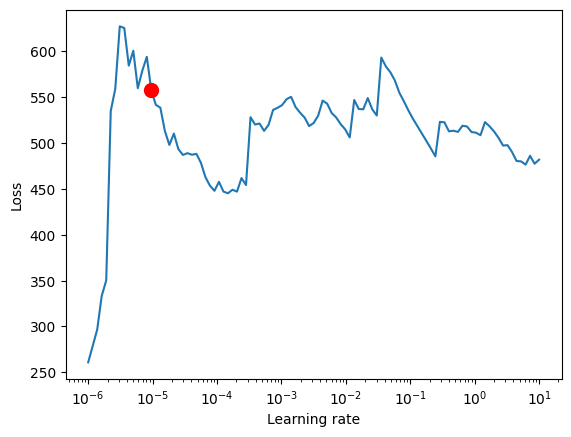

/var/folders/z0/7rx60pmj3p7dwb0h_crtphrm0000gn/T/ipykernel_38787/1657655506.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [79]:
trainer = train_step_1(training,train_dataloader,val_dataloader)

In [38]:
best_model_path = trainer.checkpoint_callback.best_model_path

In [39]:
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [54]:
predictions= best_tft.predict(val_dataloader, mode="raw",return_index=True,trainer_kwargs=dict(accelerator="cpu"))
predictions_2= best_tft.predict(val_dataloader,return_index=True,trainer_kwargs=dict(accelerator="cpu"))

/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [61]:
predictions.output.prediction.shape

torch.Size([17871, 4, 7])

In [84]:
test_df = pd.DataFrame()
import json
import numpy as np

In [91]:
test_df['y']=[json.dumps(x) for x in np.array(predictions.output.prediction)[0].tolist()]

In [94]:
test_df

,y
0,"[29.36968994140625, 339.25537109375, 556.51013..."
1,"[115.3267822265625, 152.3565673828125, 446.088..."
2,"[189.654052734375, 75.48089599609375, 372.2868..."
3,"[220.3087158203125, 386.9625244140625, 622.311..."


In [90]:
list(predictions.output.prediction)

[tensor([[  29.3697,  339.2554,  556.5101,  845.1310, 1117.1370, 1388.1908,
          2155.1680],
         [ 115.3268,  152.3566,  446.0889,  776.2400,  960.9984, 1269.9436,
          2297.4675],
         [ 189.6541,   75.4809,  372.2869,  663.4120,  827.4288, 1138.6130,
          2278.3826],
         [ 220.3087,  386.9625,  622.3112, 1011.4779, 1424.4324, 1807.3047,
          2520.1475]]),
 tensor([[8.7671e-21, 1.3607e-21, 1.0634e-19, 8.6352e-19, 1.2812e-16, 4.4959e-14,
          1.8766e-05],
         [1.6276e-20, 5.1358e-22, 6.5775e-20, 3.2215e-19, 4.8294e-18, 7.4512e-16,
          4.7756e-07],
         [1.4443e-20, 3.4870e-22, 3.0722e-20, 1.6586e-19, 1.2066e-18, 9.5839e-17,
          5.3466e-08],
         [4.2669e-19, 2.1246e-19, 9.6322e-18, 2.4114e-15, 7.7081e-12, 1.1951e-08,
          5.5407e-03]]),
 tensor([[2.3636e-20, 1.8222e-21, 1.0095e-17, 1.6127e-17, 5.4335e-13, 5.0668e-08,
          2.8502e+01],
         [3.6639e-20, 1.0810e-22, 3.4612e-18, 7.5844e-18, 9.6570e-16, 1.1694e-1

In [80]:
predictions.output.prediction[0,:,:]

tensor([[  29.3697,  339.2554,  556.5101,  845.1310, 1117.1370, 1388.1908,
         2155.1680],
        [ 115.3268,  152.3566,  446.0889,  776.2400,  960.9984, 1269.9436,
         2297.4675],
        [ 189.6541,   75.4809,  372.2869,  663.4120,  827.4288, 1138.6130,
         2278.3826],
        [ 220.3087,  386.9625,  622.3112, 1011.4779, 1424.4324, 1807.3047,
         2520.1475]])

In [81]:
predictions_2.output[0]

tensor([ 845.1310,  776.2400,  663.4120, 1011.4779])

In [55]:
predictions_2.output

tensor([[8.4513e+02, 7.7624e+02, 6.6341e+02, 1.0115e+03],
        [8.6352e-19, 3.2215e-19, 1.6586e-19, 2.4114e-15],
        [1.6127e-17, 7.5844e-18, 5.4660e-18, 3.7396e-09],
        ...,
        [1.3450e+01, 2.3298e+00, 1.1208e-03, 1.6602e+01],
        [1.2565e-08, 3.1950e-11, 1.4353e-12, 3.6847e-10],
        [2.3089e-10, 1.0656e-12, 1.1562e-13, 8.5053e-11]])

In [45]:
predictions.index

,time_idx,unique_id
0,23,100002497
1,23,100002552
2,23,100005774
3,23,100007354
4,23,100007373
...,...,...
17866,23,821013000600
17867,23,821098010900
17868,23,821098011000
17869,23,821098011400


In [37]:
predictions.index

,time_idx,unique_id
0,23,100002497
1,23,100002552
2,23,100005774
3,23,100007354
4,23,100007373
...,...,...
17866,23,821013000600
17867,23,821098010900
17868,23,821098011000
17869,23,821098011400


In [41]:
def forcast_future_old(best_tft,df_filter,forecast_length,price_df=None):
    # select last 24 months from data (max_encoder_length is 24)
    max_encoder_length=forecast_length*4
    max_prediction_length = forecast_length
    encoder_data = df_filter[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

    # select last known data point and create decoder data from it by repeating it and incrementing the month
    # in a real world dataset, we should not just forward fill the covariates but specify them to account
    # for changes in special days and prices (which you absolutely should do but we are too lazy here)
    last_data = df_filter[lambda x: x.time_idx == x.time_idx.max()]
    decoder_data = pd.concat(
        [last_data.assign(year_month=lambda x: x.year_month + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
        ignore_index=True,
    )

    # add time index consistent with "data"
    decoder_data["time_idx"] = decoder_data["year_month"].dt.year * 12 + decoder_data["year_month"].dt.month
    decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

    # adjust additional time feature(s)
    decoder_data["month"] = decoder_data.year_month.dt.month.astype(str).astype("category")  # categories have be strings
    decoder_data['year_month'] = decoder_data['year_month'].dt.date
    # combine encoder and decoder data
    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    return new_prediction_data

In [42]:
new_prediction_data = forcast_future_old(best_tft,df_filter,4)

In [43]:
prediction_new = best_tft.predict(new_prediction_data,return_x=True,return_index=True,trainer_kwargs=dict(accelerator="cpu"))

/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [45]:
prediction_new.output,prediction_new.index

(tensor([[8.1059e+02, 8.3601e+02, 8.6534e+02, 8.8542e+02],
         [1.7936e-16, 2.8993e-16, 4.7333e-16, 5.6740e-16],
         [1.9522e-11, 5.7155e-11, 2.1539e-10, 3.9157e-10],
         ...,
         [4.8915e-05, 5.5246e-04, 7.5134e-03, 4.7399e-02],
         [7.3512e-11, 2.5962e-10, 7.9158e-10, 1.5298e-09],
         [7.2752e-11, 2.6028e-10, 8.3129e-10, 1.6798e-09]]),
        time_idx     unique_id
 0            27     100002497
 1            27     100002552
 2            27     100005774
 3            27     100007354
 4            27     100007373
 ...         ...           ...
 17866        27  821013000600
 17867        27  821098010900
 17868        27  821098011000
 17869        27  821098011400
 17870        27  821098011500
 
 [17871 rows x 2 columns])

In [49]:
prediction_new.output[0][1]

tensor(836.0087)

In [50]:
71484/4

17871.0

In [80]:
def pre_price_data(df):
    df = df.rename(columns={
        'ymonth': 'year_month',
        'item_code': 'unique_id',
    })
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y%m')
    df['year'] = df['year_month'].dt.year
    df['month'] = df['year_month'].dt.month
    df["month"] = df["month"].astype(str).astype("category")
    df["year"] = df["year"].astype(str).astype("category")
    df['unique_id'] = df['unique_id'].astype(str).astype("category")
    df.drop_duplicates(subset=['unique_id',"month","year"],inplace=True)
    return df

In [81]:
price_df = pd.read_csv('./data/pricefile.csv')

In [82]:
price_df = pre_price_data(price_df)

In [83]:
price_df.head()

,year_month,unique_id,unit_price,year,month
0,2023-04-01,100002497,15.102771,2023,4
1,2023-04-01,100002552,3.000000,2023,4
2,2023-04-01,100005774,32.442857,2023,4
3,2023-04-01,100007354,1.888544,2023,4
4,2023-04-01,100007373,17.567901,2023,4


In [78]:
def forcast_future(best_tft,df_filter,forecast_length,price_df=''):
    # select last 24 months from data (max_encoder_length is 24)
    max_encoder_length=forecast_length*4
    max_prediction_length = forecast_length
    encoder_data = df_filter[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

    # select last known data point and create decoder data from it by repeating it and incrementing the month
    # in a real world dataset, we should not just forward fill the covariates but specify them to account
    # for changes in special days and prices (which you absolutely should do but we are too lazy here)
    last_data = df_filter[lambda x: x.time_idx == x.time_idx.max()]
    decoder_data = pd.concat(
        [last_data.assign(year_month=lambda x: x.year_month + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
        ignore_index=True,
    )

    # add time index consistent with "data"
    decoder_data["time_idx"] = decoder_data["year_month"].dt.year * 12 + decoder_data["year_month"].dt.month
    decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

    # adjust additional time feature(s)
    decoder_data["month"] = decoder_data.year_month.dt.month.astype(str).astype("category")  # categories have be strings
    decoder_data['year_month'] = decoder_data['year_month'].dt.date
    # combine encoder and decoder data
    new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
    print(new_prediction_data.shape)
    if len(price_df)>0:
        new_prediction_data = pd.merge(new_prediction_data,price_df,how='left',left_on=['unique_id','year','month'],right_on=['unique_id','year','month'],suffixes=('', '_y'))
        new_prediction_data['price'] = new_prediction_data.apply(lambda row:row['unit_price'] if row['unit_price']>0 else row['price'],axis=1)
    print(new_prediction_data.shape)
    return new_prediction_data

In [84]:
new_prediction_data = forcast_future(best_tft,df_filter,4,price_df)

(357420, 36)
(357420, 38)


In [76]:
new_prediction_data[new_prediction_data.unique_id=='821098011000'].T

,285888,285889,285890,285891,285892,285893,285894,285895,285896,285897,...,285901,285902,285903,307712,307713,329493,329494,351274,351275,369147
year,2021,2022,2022,2022,2022,2022,2022,2022,2022,2022,...,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023
month,12,1,2,3,4,5,6,7,8,9,...,1,2,3,4,4,5,5,6,6,7
unique_id,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,...,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000,821098011000
big_class_name,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,...,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17,5443a365f869375a9dff2489abd15a17
second_pdt_name,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,...,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4,e444cda95479761444a00bbf95b7dfc4
pdt_name,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,...,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce,4b7a9ca2857f8b4b01bec0cae2d8d5ce
cat_name,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,...,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb,3e45b997ff62cc2c3fc8b0fcb63d2efb
second_pdt,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,...,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0,1004017.0
pdt,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,...,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0,1004007.0
office,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,...,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0


In [85]:
predictions = best_tft.predict(new_prediction_data, return_x=True,return_index=True,trainer_kwargs=dict(accelerator="cpu"))
    

/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/shnguo/miniconda3/envs/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [86]:
price_df[price_df.unique_id=='821098011000']

,year_month,unique_id,unit_price,year,month
23248,2023-04-01,821098011000,244.743834,2023,4
52877,2023-05-01,821098011000,244.743834,2023,5
82506,2023-06-01,821098011000,244.743834,2023,6
